# Educational Toolkit for Mapping Large Ensembles

This is an educational toolkit to demonstrate how to deal with CESM1 data. 

Things to note: 

- We are using the Ocean model from CESM1
- The data is hosted on Amazon Web Services (AWS), however this data is freely available so no account for AWS is necessary.
- We are investigating different experiments through the Ocean Model.
- We are only looking at few variables. All variables available through the CESM1 data are found on the link below: 
https://www.cesm.ucar.edu/community-projects/lens2/output-variables

## Data Access

This section shows a detailed description and a step-by-step process of accessing the CESM1 data catalog through Pangeo tuturials on AWS. 

Here we are: 

- Accessing the OCN model dataset with RCP 8.5 and 20C runs. 
- Narrowing down the columns to specific variables we aim to access.

For example: 
``` 
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)
```
- Loading in lat/lon data separately which was not in CESM1 as of May 2024. 

This section works similar to accessing other catalogs, we will be using Zarr. More information on the library below.

https://zarr.readthedocs.io/en/stable/

In [3]:
# Packages needed generally
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import numpy as np
import xesmf as xe

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs
import dask

The code below above assigns a variable to the url we will use to access the data. The `intake.open_esm_datastore` is an intake plugin for parsing the ESM (Earth System Model) catalog and loads the assets into an xarray dataset. If you are interested in learning more about the intake plugin, you can find more information at this link: https://intake-esm.readthedocs.io/en/stable/reference/api.html.



In [4]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"

By calling the .search() method on the collection object, we can search for specific datasets that match our criteria. For example, we can search and modigy the search to find the variables associated with the 'ocn' model. 


In [5]:
# Search for all possible variables for OCN component 
col.search(component="ocn").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,DIC,dissolved inorganic carbon,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-DIC...
1,DOC,dissolved organic carbon,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-DOC...
2,FW,freshwater flux,ocn,20C,monthly,1.0,global_ocean,centimeter/s,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-FW....
3,HMXL,mixed-layer depth,ocn,20C,monthly,1.0,global_ocean,centimeter,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-HMX...
4,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
...,...,...,...,...,...,...,...,...,...,...,...
123,WVEL,vertical velocity,ocn,RCP85,monthly,60.0,global_ocean,centimeter/s,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-W...
124,NaN,NaN,ocn,CTRL,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
125,NaN,NaN,ocn,HIST,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
126,NaN,NaN,ocn,RCP85,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr


In [6]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 scenarios
variables = ["SST", "SALT", "O2"]
col_ocn = {}

for var in variables:
    col_ocn[f"{var}"] = col.search(
        frequency=["monthly"],
        component="ocn",
        variable=var,
        experiment=["20C", "RCP85"],
    )

print(col_ocn)

#Display the first few entries in the resulting data frame
col_ocn["SST"].df
col_ocn["SALT"].df
col_ocn["O2"].df

{'SST': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>, 'SALT': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>, 'O2': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>}


,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
1,O2,dissolved oxygen,ocn,RCP85,monthly,60.0,global_ocean,mmol/m^3,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-O...


The reasoning behind creating a for loop to iterate over the variables is because loading in the full data gives a warning that the size of the data is too large. By loading in the data in chunks, we can avoid this warning.

For this particular notebook, we are interesting in monthly data spanning from 1920 to 2100. Historical data is from 1920 to 2005 and RCP 8.5 is from 2006 to 2100. Our variables of interest were pre-determined by the Channel Islands Sanctuary staff, so we are only interested in the following variables:

- SST (Sea Surface Temperature)
- O2 (Dissolved Oxygen)
- SALT (Salinity)


In [7]:
# Load catalog entries for subset into a dictionary of xarray datasets
#Lets create another for loop to iteratre over the col_ocn dictionary

dsets = {}
for var in variables:
    dsets[var] = col_ocn[var].to_dataset_dict(
        zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
    )
    print(f"\nDataset dictionary keys for {var}:\n {dsets[var].keys()}")



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for SST:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for SALT:
 dict_keys(['ocn.20C.monthly', 'ocn.RCP85.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for O2:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])


Now let's load in our grid data:

In [8]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True)

The code chunk above loads in the catalog entries into a dictionary of xarray datasets. The dictionary is then used to load the data into a single xarray dataset.

Now let's assign a variable to each of the datasets we are interested in.

In [9]:
# Define Xarray datasets corresponding to the two experiments by each variable 
ds_20C_SST = dsets["SST"]["ocn.20C.monthly"]
ds_RCP85_SST = dsets["SST"]["ocn.RCP85.monthly"]

ds_20C_SALT = dsets["SALT"]["ocn.20C.monthly"]
ds_RCP85_SALT = dsets["SALT"]["ocn.RCP85.monthly"]

ds_20C_O2 = dsets["O2"]["ocn.20C.monthly"]
ds_RCP85_O2 = dsets["O2"]["ocn.RCP85.monthly"]



## Data Exploration

In this part of the tutorial we will conduct preliminary data exploration to understand the large ensembles we are working with. This data is extremely large, so most of our data exploration is shown through "lazyloading." 

Here we can explore different variables, and the column names.

We have loaded and assigned each of the variables we are going to use above, and each of these contain the same amount of columns and rows. Let's take a look at the dataframe for Sea Surface Temperature (SST) under 20C. 


In [10]:
ds_20C_SALT

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1032, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SALT        (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    nsteps_total:                      750
    ...                                ...
    intake_esm_attrs:units:            gram/kilogram
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

This is an overwhelming amount of information for this data. Let's breakdown the dimensions down:

- member_id: There are 40 members in this ensemble, each with a unique ID (1-40). This data is used to represent the different initial conditions for the model. 
- time: This is the time dimension, and it is in monthly intervals, and since this is loaded 20C data, this represents time from 1920 to 2005.
- nlat: This is the number of latitude points in the grid.
- nlon: This is the number of longitude points in the grid.

Each of the loaded datasets contain the same dimensions, with only the data variable and time frame varying.


## Data Wrangling

Although data that is made avaiable through the CESM1 model is clean and ready to use, we only want to extract a certain part of the world. This is the Channel Islands Marine Sanctuary and surrounding areas.  


In this section we will demonstrate how to: 
- Merge the grid data and the variable data to create a single dataset.
- Regrid the data by creating a new grid that resembles actual longitude/lattitude coordinates.

In our analysis, we will be selecting the full time frame, but if you desire to select a specific time frame, you can do so by using the `.sel()`argument

After selecting the time frame, you will be able to plot `test_1950` to see the entire world, but we want to extract a specific region. In order to do that we will need to merge the grid data and the variable data.

In [11]:
#subset tlat and tlong first from the grid
grid_sub = grid[['TLAT' , 'TLONG', 'nlat', 'nlon']]

grid_sub.load()

#merge the grid with the data by using a for loop to iterate over the current datasets we have.
var_experiments = [ds_20C_SST, ds_RCP85_SST, ds_20C_SALT, ds_RCP85_SALT, ds_20C_O2, ds_RCP85_O2]

merged_datasets = []

for dataset in var_experiments:
    merged_dataset = dataset.merge(grid_sub)
    merged_dataset = merged_dataset.rename({'TLAT': 'lat', 'TLONG': 'lon'})
    merged_datasets.append(merged_dataset)
    print(f"Merged Dataset: {merged_dataset}")

#Now lets assign the merged datasets to the variables
merged_20C_sst = merged_datasets[0]
merged_rcp85_sst = merged_datasets[1]
merged_20C_salt = merged_datasets[2]
merged_rcp85_salt = merged_datasets[3]
merged_20C_o2 = merged_datasets[4]
merged_rcp85_o2 = merged_datasets[5]


Merged Dataset: <xarray.Dataset>
Dimensions:             (member_id: 40, time: 1032, z_t: 1, nlat: 384,
                         nlon: 320, d2: 2)
Coordinates: (12/57)
  * member_id           (member_id) int64 1 2 3 4 5 6 ... 35 101 102 103 104 105
  * time                (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:0...
    time_bound          (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t                 (z_t) float32 500.0
  * nlat                (nlat) int64 0 1 2 3 4 5 6 ... 378 379 380 381 382 383
  * nlon                (nlon) int64 0 1 2 3 4 5 6 ... 314 315 316 317 318 319
    ...                  ...
    salt_to_ppt         float64 1e+03
    sea_ice_salinity    float64 4.0
    sflux_factor        float64 0.1
    sound               float64 1.5e+05
    stefan_boltzmann    float64 5.67e-08
    vonkar              float64 0.4
Dimensions without coordinates: d2
Data variables:
    SST                 (member_id, time, z_t, nlat, nlon) float32 das

Now since the data that we currently have is in a different format than needed for our analysis, we will regrid the data to resemble actual longitude and latitude coordinates.

In [12]:
# define a 'target' grid. This is simply a regular lon/lat grid that we will interpolate our data on
ds_target = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, 1.0), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(0, 360, 1.0), {"units": "degrees_east"}),
    }
)  
ds_target

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    *empty*

In [13]:
# List of merged datasets
merged_datasets = [merged_20C_sst, merged_rcp85_sst, merged_20C_salt, merged_rcp85_salt, merged_20C_o2, merged_rcp85_o2]

regridded = []

for merged_dataset in merged_datasets:
    # Define the regridder object
    regridder = xe.Regridder(merged_dataset, ds_target, "nearest_s2d", periodic=True)
    
    # Regrid the merged dataset
    regridded_data = regridder(merged_dataset)
    
    regridded.append(regridded_data)


In [14]:
#now lets reapply the data to the regridder
SST_20C_regrid = regridded[0]
SST_RCP85_regrid = regridded[1]
SALT_20C_regrid = regridded[2]
SALT_RCP85_regrid = regridded[3]
O2_20C_regrid = regridded[4]
O2_RCP85_regrid = regridded[5]

#select the depth dimension as well 
SALT_20C_regrid


<xarray.Dataset>
Dimensions:             (member_id: 40, time: 1032, z_t: 60, lat: 180,
                         lon: 360, d2: 2)
Coordinates: (12/36)
  * member_id           (member_id) int64 1 2 3 4 5 6 ... 35 101 102 103 104 105
  * time                (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:0...
    time_bound          (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
    T0_Kelvin           float64 273.1
    cp_air              float64 1.005e+03
    ...                  ...
    sflux_factor        float64 0.1
    sound               float64 1.5e+05
    stefan_boltzmann    float64 5.67e-08
    vonkar              float64 0.4
  * lat                 (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * lon                 (lon) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Dimensions without coordinates: d2
Data variables:
    SALT                (member_id, time, z_t, lat, lon) float32 dask.array<chunksize=(1, 6, 60, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  nearest_s2d


This function will have successfully applied the regridder function to normal lat/lon values.

## Plotting Visuals

Plotting the type of vizualization method, in this section we are mapping the variables. 

This section shows how to properly display the spatial distribution of the variables you are plotting. We will demonstrate some difference plots and maps of data from certain time frames. 

In this chunk below we are doing a couple things: 
1. Calculating the mean of all ensembles and time. 
    - But we will also demonstrate how to select a specific ensemble and time frame.
2. Using the `.where` function to subset Channel Islands and surrounding waters to plot the data.
3. Plotting a shape file over the data to show the Channel Islands Marine Sanctuary.

In [15]:
#Now lets calculate the global mean SST for the 20th century and RCP8.5 scenarios
SST_20C_final = SST_20C_regrid.SST.mean(dim = ["member_id", "time"])
SST_RCP85_final = SST_RCP85_regrid.SST.mean(dim = ["member_id", "time"])


In [16]:
# Approximate latitude range for southern California
lat_range = (30, 35)
# Approximate longitude range for southern California
lon_range = (235, 245)
# Subset the data based on the latitude and longitude ranges for 20C scenario
SST_20C_final = SST_20C_final.where((SST_20C_final.lat >= lat_range[0]) & (SST_20C_final.lat <= lat_range[1]) &
                                 (SST_20C_final.lon >= lon_range[0]) & (SST_20C_final.lon <= lon_range[1]),
                                 drop=True)
#repeat the same process for RCP8.5
SST_RCP85_final = SST_RCP85_final.where((SST_RCP85_final.lat >= lat_range[0]) & (SST_RCP85_final.lat <= lat_range[1]) &
                                    (SST_RCP85_final.lon >= lon_range[0]) & (SST_RCP85_final.lon <= lon_range[1]),
                                    drop=True)

SST_20C_final



<xarray.DataArray 'SST' (z_t: 1, lat: 6, lon: 11)>
dask.array<where, shape=(1, 6, 11), dtype=float32, chunksize=(1, 6, 11), chunktype=numpy.ndarray>
Coordinates: (12/33)
  * z_t                 (z_t) float32 500.0
    T0_Kelvin           float64 273.1
    cp_air              float64 1.005e+03
    cp_sw               float64 3.996e+07
    days_in_norm_year   timedelta64[ns] 365 days
    fwflux_factor       float64 0.0001
    ...                  ...
    sflux_factor        float64 0.1
    sound               float64 1.5e+05
    stefan_boltzmann    float64 5.67e-08
    vonkar              float64 0.4
  * lat                 (lat) float64 30.0 31.0 32.0 33.0 34.0 35.0
  * lon                 (lon) float64 235.0 236.0 237.0 ... 243.0 244.0 245.0

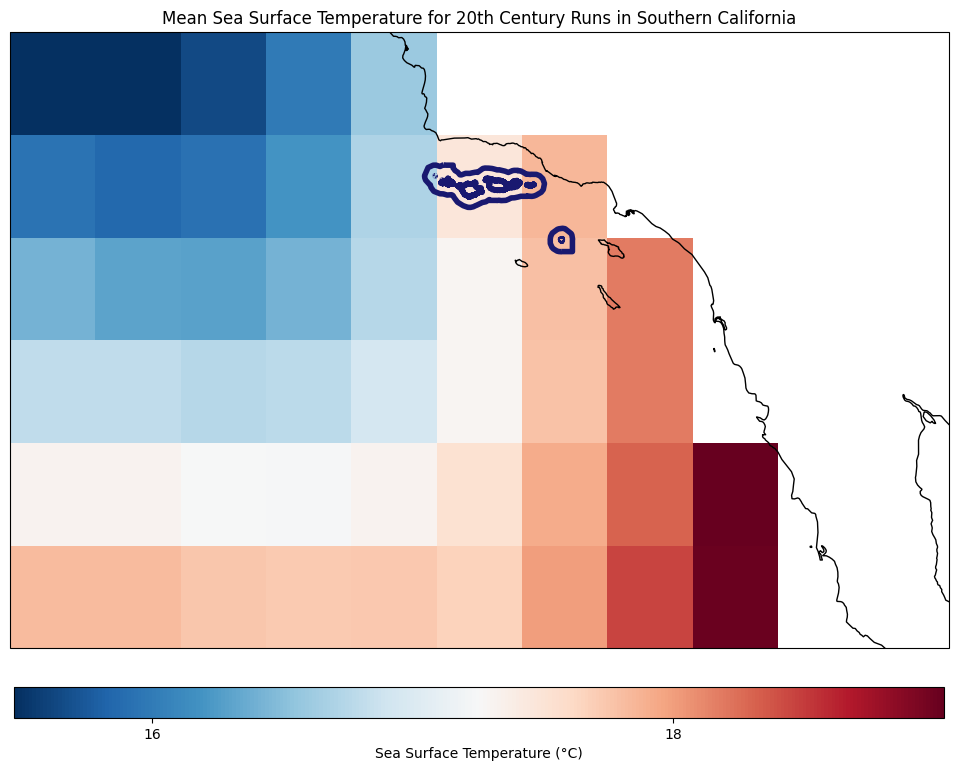

In [17]:
# Plot the subset data
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# Reverse the colormap
cmap = plt.cm.RdBu_r 
#lets make the plot contour rather than patch by using the contourf function
SST_20C_final.plot(ax=ax, 
                 transform=ccrs.PlateCarree(), 
                 cmap=cmap,
                 cbar_kwargs={'orientation': 'horizontal', 
                              'label': 'Sea Surface Temperature (°C)', 
                              'shrink': 0.8, 
                              'pad': 0.05, 
                              'aspect': 30,
                              #edit the ticks on the cbar
                              'ticks': np.arange(10, 30, 2)})
#Lets set the color bar on top of the plot, lets provide the cax argument to the colorbar function
ax.coastlines()
#lets throw the shape file in here 
shp = gpd.read_file('cinms_py')
shp.boundary.plot(ax=ax, 
                  color='midnightblue', 
                  linewidth=4)
ax.set_title('Mean Sea Surface Temperature for 20th Century Runs in Southern California')
plt.show()

Now let's print out the Sea Surface Temperature map for RCP8.5 runs. 

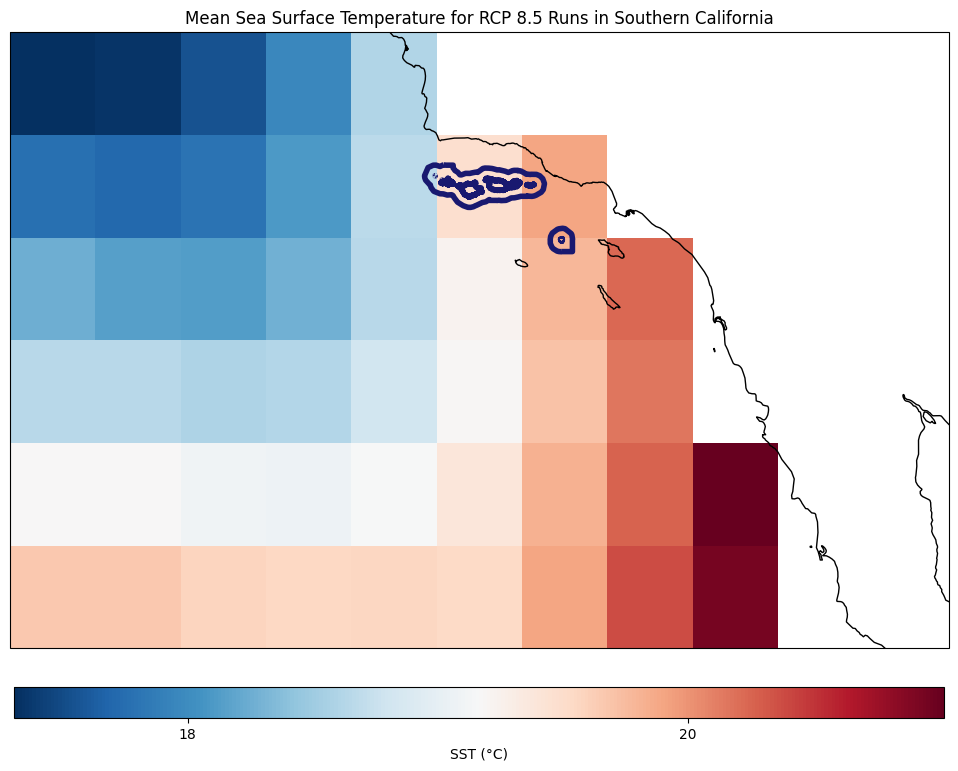

In [18]:
# Plot the subset data
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
#lets make the plot contour rather than patch by using the contourf function
SST_RCP85_final.plot(ax=ax, 
                 transform=ccrs.PlateCarree(), 
                 cmap=cmap,
                 cbar_kwargs={'orientation': 'horizontal', 
                              'label': 'SST (°C)', 
                              'shrink': 0.8, 
                              'pad': 0.05, 
                              'aspect': 30,
                              #edit the ticks on the cbar
                              'ticks': np.arange(10, 30, 2)})
#Lets set the color bar on top of the plot, lets provide the cax argument to the colorbar function
ax.coastlines()
#lets throw the shape file in here 
shp.boundary.plot(ax=ax, 
                  color='midnightblue', 
                  linewidth=4)
ax.set_title('Mean Sea Surface Temperature for RCP 8.5 Runs in Southern California')
plt.show()

Now let's repeate the same process with the other variables. I will use similae 

In [36]:
# Subset the data based on the latitude and longitude ranges for 20C scenario
SALT_20C_final = SALT_20C_regrid.where((SALT_20C_regrid.lat >= lat_range[0]) & (SALT_20C_regrid.lat <= lat_range[1]) &
                                 (SALT_20C_regrid.lon >= lon_range[0]) & (SALT_20C_regrid.lon <= lon_range[1]),
                                 drop=True)

SALT_RCP85_final =SALT_RCP85_regrid.where((SALT_RCP85_regrid.lat >= lat_range[0]) & (SALT_RCP85_regrid.lat <= lat_range[1]) &
                                    (SALT_RCP85_regrid.lon >= lon_range[0]) & (SALT_RCP85_regrid.lon <= lon_range[1]),
                                    drop=True)

#Now lets calculate the global mean SST for the 20th century and RCP8.5 scenarios
SALT_20C_final = SALT_20C_final.SALT.mean(dim = "member_id")
SALT_RCP85_final = SALT_RCP85_final.SALT.mean(dim = "member_id")

# # #Now let's calculate the mean of the depth dimension for only a few, it will take too long to calculate the mean of the entire dataset (runs for +2hrs)
SALT_20C_final = SALT_20C_final.sel(z_t=0, method = "nearest")
SALT_RCP85_final = SALT_RCP85_final.sel(z_t=0, method = "nearest")

SALT_20C_final

<xarray.DataArray 'SALT' (time: 1032, lat: 6, lon: 11)>
dask.array<getitem, shape=(1032, 6, 11), dtype=float32, chunksize=(6, 6, 11), chunktype=numpy.ndarray>
Coordinates: (12/34)
  * time                (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:0...
    z_t                 float32 500.0
    T0_Kelvin           float64 273.1
    cp_air              float64 1.005e+03
    cp_sw               float64 3.996e+07
    days_in_norm_year   timedelta64[ns] 365 days
    ...                  ...
    sflux_factor        float64 0.1
    sound               float64 1.5e+05
    stefan_boltzmann    float64 5.67e-08
    vonkar              float64 0.4
  * lat                 (lat) float64 30.0 31.0 32.0 33.0 34.0 35.0
  * lon                 (lon) float64 235.0 236.0 237.0 ... 243.0 244.0 245.0

In [37]:
# Plot the subset data
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
#lets make the plot contour rather than patch by using the contourf function
SALT_20C_final.sel(time = "1950-03").plot(ax=ax, 
                 transform=ccrs.PlateCarree(), 
                 cmap="viridis",
                 cbar_kwargs={'orientation': 'horizontal', 
                              'label': 'Salinity (PSU)', 
                              'shrink': 0.8, 
                              'pad': 0.05, 
                              'aspect': 30})
#Lets set the color bar on top of the plot, lets provide the cax argument to the colorbar function
ax.coastlines()
#lets throw the shape file in here 
shp = gpd.read_file('cinms_py')
shp.boundary.plot(ax=ax, 
                  color='forestgreen', 
                  linewidth=4)
ax.set_title('Mean Salinity for 20th Century Runs in Southern California')
plt.show()